## <center>DCGANs - Deep Convolutional Gerative Adverserial Networks</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.datasets import mnist

import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

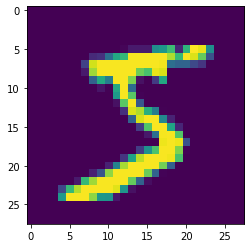

In [3]:
plt.imshow(X_train[0])

### Reshape and Rescale Images for DCGAN

Generator will use tanh activation function for the last layer, so we want to reshape X_train to be within -1 to 1 limits.

In [4]:
scaler = MinMaxScaler(feature_range=(-1, 1))

X_train = scaler.fit_transform(X_train.reshape(-1, 28*28))

In [5]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_train.max(), X_train.min()

(1.0, -1.0)

#### Filtering out the Data for Faster Training on Smaller Dataset

In [6]:
only_zeros = X_train[y_train==0]
only_zeros.shape

(5923, 28, 28, 1)

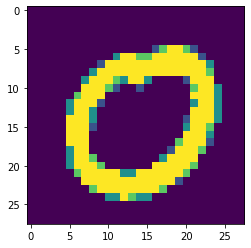

In [7]:
plt.imshow(only_zeros[950])

### Building the Generator and Discriminator

In [8]:
codings_size = 100

generator = Sequential()
generator.add(Dense(7 * 7 * 128, input_shape=[codings_size]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"))
# Since we use this model to generate images from one-dimensional input, using Transposed Convolution layers is the best 
# option. Transposed Convolution layers work just the opposite of the Convolution layer. They increase the definition of 
# image data.

generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh"))
generator.add(Reshape([28,28, 1]))


In [9]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[28, 28, 1]))
                        
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

In [10]:
GAN = Sequential([generator, discriminator])

In [11]:
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False

In [12]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [13]:
GAN.layers

In [14]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         840705    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


In [15]:
GAN.layers[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                        

In [16]:
GAN.layers[1].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212,865
Trainable params: 0
Non-trainabl

In [17]:
batch_size = 32
my_data = only_zeros

dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

epochs = 20

### Training Loop

In [18]:
# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0

    # For every batch in the dataset
    for X_batch in dataset:
        
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################

        # STEPS:
        
        # 1. Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # 2. Generate numbers based just on noise input --> generator never sees the actual images, only sees noise
        gen_images = generator(noise)
        
        # 3. Concatenate Generated Images against the Real Ones
        X_fake_vs_real = tf.concat(
            [   gen_images, 
                tf.dtypes.cast(X_batch,tf.float32) # TO use tf.concat, the data types must match!
            ], axis=0)
        
        # 4. Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.0]] * batch_size + [[1.0]] * batch_size)
        
        # 5. Make the discriminator trainable
        discriminator.trainable = True
        
        # 6. Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################

        # STEPS:
        
        # 1. Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # 2. We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.0]] * batch_size)
        
        # 3. Enable the GAN to be trained, in this case the generator is trained through the GAN
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")      

Currently on Epoch 1
Currently on Epoch 2
Currently on Epoch 3
Currently on Epoch 4
Currently on Epoch 5
Currently on Epoch 6
Currently on Epoch 7
Currently on Epoch 8
Currently on Epoch 9
Currently on Epoch 10
Currently on Epoch 11
Currently on Epoch 12
Currently on Epoch 13
Currently on Epoch 14
Currently on Epoch 15
Currently on Epoch 16
Currently on Epoch 17
Currently on Epoch 18
Currently on Epoch 19
Currently on Epoch 20
TRAINING COMPLETE


In [19]:
noise = tf.random.normal(shape=[10, codings_size])
noise.shape

TensorShape([10, 100])

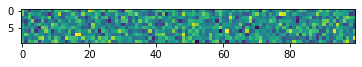

In [20]:
plt.imshow(noise)

In [21]:
images = generator(noise)
images.shape

TensorShape([10, 28, 28, 1])

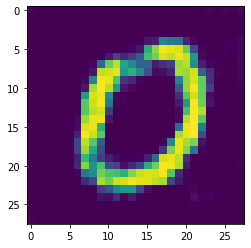

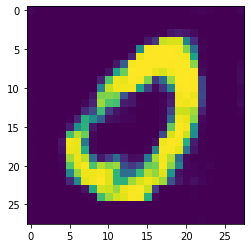

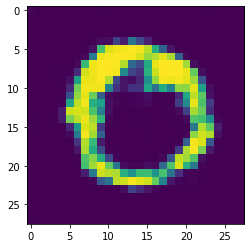

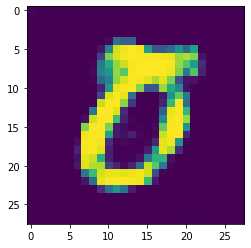

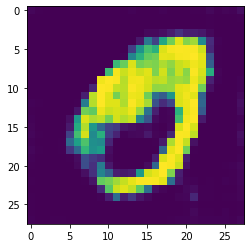

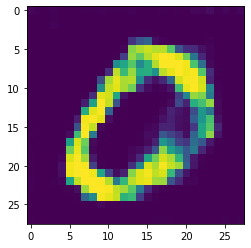

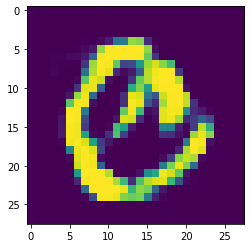

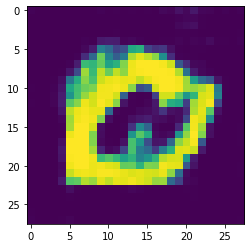

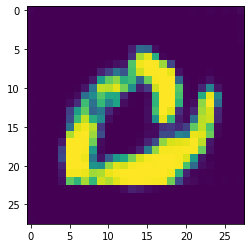

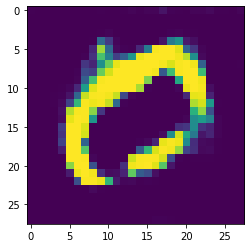

In [22]:
for image in images:
    plt.imshow(image)
    plt.show()